In [237]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

from sklearn import linear_model
from sklearn.model_selection import cross_val_score

<b><h3>Fancy Tricks with Simple Numbers</h3></b>

The simplest of data types is numeric data (as opposed to text or image). This may come from a variety of sources eg geolocation data, sensor data, price data, traffic counts etc. Numeric data is already in a format that is easily ingestible by mathematical models. This doesnt mean that feature engineering is no longer necessary, though. Good features should not only represent salient aspects of the data, but also conform to the assumptions of the model. Hence, transformations are often necessary. Numeric feature engineering techniques are fundamental. They can be applied whenever raw data is converted into numeric features.

The first sanity check for numeric data is whether the magnitude matters. Do we just need to know whether its positive or negative? Or perhaps we only need to know the magnitude at a very coarse granularity. This sanity check is particularly important for automatically accrued numbers such as counts - the number of daily visits to a website, the number of reviews garnered by a restaurant etc.

Next, consider the scale of the features. What are the largest and the smallest values? Do they span several orders of magnitude? Models that are smooth functions of input features are sensitive to the scale of the input. For example, 3𝒳 + 1 is a simple linear function of the input 𝒳, and the scale of its output depends directly on the scale of the input. Other examples include k-means clustering, nearest neighbors methods, radial basis function (RBF) kernels, and anything that uses the Euclidean distance. For these models and modeling components, it is often a good idea to normalize the features so that the output stays on an expected scale.

Logical functions, on the other hand, are not sensitive to input feature scale. Their output is binary no matter what the inputs are. For instance, the logical AND takes any two vairables and outputs 1 if and only if both of the inputs are true. Another example of a logical function is the step function (eg is input x greater than 5?). Decision tree models consist of step functions of input features. Hence, models based on space-partitioning trees (decision trees, gradient boosted machines, random forests) are not sensitive to scale. The only exception is if the scale of the input grows over time, which is the case if the feature is an accumulated count of some sort - eventually it will grow outside the range that the tree is trained on. If this might be the case, then it might be necessary to rescale the inputs periodically. Another solution is the bin-counting method.

It's also important to consider the distribution of numeric features. Distribution summarizes the probability of taking on a particular value. The distribution of input features matters to some models more than others. For instance, the training process of a linear regression model assumes that prediction errors are distributed like a Gaussian. This is usually fine, except when the prediction target spreads out over several orders of magnitude. In this case, the Gaussian error assumption likely no longer holds. One way to deal with this is to transform the output target in order to tame the magnitude of the growth. (Strictly speaking this would be target engineering, not feature engineering.) Log transforms, which are a type of power transform, take the distribution of the variable closer to Gaussian.

In addition to features tailoring to the assumptions of the model or training process, multiple features can be composed together into more complex features. The hop is that complex features can more succinctly capture important information in raw data. Making the input features more 'eloquent' allows the model itself to be simpler, easier to train and evaluate, to make better predictions. Taken to an extreme, complex features may themselves be the output of statistical models. This is a concept known as model stacking. The simplest example of complex features is interaction features.

Interaction features are simple to formulate, but the combination of features results in many more being input into the model. In order to reduce the computational expense, it is usually necessary to prune the input features using automatic feature selection.

<b><h4>Scalars, Vectors, and Spaces</h4></b>

A single numeric feature is also known as a scalar. An ordered list of scalars is known as a vector. Vectors sit within a vector space. In the vast majority of machine learning applications, the input to a model is usually represented as a numeric vector. A vector can be visualized as a point in space, sometimes people draw a line or arrow from the origin to that point. Suppose we have a two-dimensional vector v = [1, -1]. The vector contains two numbers: the first direction, d<sub>1</sub>, the vector has a value of 1, and in the second direction, d<sub>2</sub>, it has a value of -1.

In the world of data, an abstact vector and its feature dimensions take on actual meaning. For instance, a vector can represent a person's preference for songs. Each song is a feature, where a value 1 is equivalent to a thumbs-up, and -1 a thumbs-down. Suppose the vector v represents the preferences of a listener. Other people might have different preferences. Collectively a collection of data can be visualized in feature space as a point cloud.

Conversely a song can be represented by the individual preferences of a group of people. Suppose there are only two listeners. Then we song can be a point in the space of listeners. Just like we visualize data in a feature space, we can visualize features in a data space. In the feature space we have different songs on the axis and the preferences of different users as points. In the data space, we have different users on the axis and the songs are points based on the preferences of the users.

<b><h3>Dealing with Counts</h3></b>

In the age of Big Data, counts can quickly accumulate without bound. A user might put a song or a movie on infinite playback or use a script to repeatedly check for the availability of tickets for a popular show, which will cause the play count or website visit count to quickly rise. When data can be produced at high volumne and velocity, its very likely to contain a few extreme values. It is a good idea to check the scale and determine whether to keep the data as raw numbers, convert them into binary values to indicate presence, or bin them into coarser granularity.

In [238]:
df = pd.read_csv('../datasets/OnlineNewsPopularity/OnlineNewsPopularity.csv', delimiter=', ')

/var/folders/35/13t91srs6wg9ml5d___c_nh40000gn/T/ipykernel_2432/1464494065.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('../datasets/OnlineNewsPopularity/OnlineNewsPopularity.csv', delimiter=', ')


<b><h4>Binarization</h4></b>

Given a dataset of user ID, song ID and listen count, suppose our task is to build a recommender to recommend songs to users. One component of the recommender might predict how much a user will enjoy a particular song. Since the data contains actual listen counts, should the target be the prediction? That is should we be predicting how many times a listener would listen to that song? That would be the right thing to do if a large listen count means the user really likes the song and a low listen count means they're not interested in it. However, such data might show that while 99% of the listen counts are say 24 or lower, some listen counts are in the thousands. Such values are anomalously large; if we were to try to predict the actual listen counts, the model would be pulled off course by these large values. In other words, listen count is not a robust measure of user taste. In statistical lingo, robustness means that the method works under a wide variety of conditions. Users have different listening habits. Some people might put their favorite sngs on infinite loop, while others might savor them only on special occasions. We can't necessarily say that someone who listens to a song 20 times must like it twice as much as someone else who listens to it 10 times.

A more robust representation of user preference is to binarize the count and clip all counts greater than 1 to 1. In other words, if the user listened to a song at least once, then we count it as the user liking the song. This way, the model will not need to spend cycles on predicting the minute differences between the raw counts. The binary target is a simple and robust measure of user preference. Thus if the dataset only contains non-zero counts, then to binarize the count, we just need to set the entire listener count column to 1. This is an example where we engineer the target variable of the model. Strictly speaking, the target is not a feature because it's not the input. But on occasion we do need to modify the target in order to solve the right problem.

<Axes: >

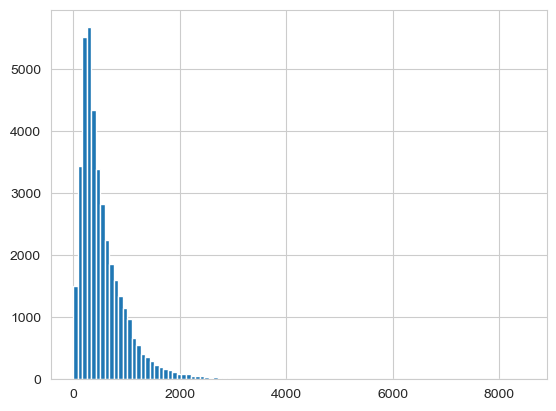

In [239]:
df['n_tokens_content'].hist(bins=100)

<b><h4>Quantization or Binning</h4></b>

Given a dataset containing reviews on businesses. Each business has a review count. Suppose our task is tpredict the rating a user might give to a business. The review count might be a useful input feature because there is usually a strong correlation between popularity and good ratings. Here popularity is reflected in the total review count of a business. Now the question is, should we use the raw count or process its further?

Raw counts that span several orders of magnitude are problematic for many models. In a linear model, the same linear coefficient would have to work for all possible values of the count. Large counts could also wreck havoc in unsupervised learning methods such as k-means clustering, which uses Euclidean distance as a similarity function to measure the similarity between data points. A large count in one element of the data vector would outweigh the similarity in all other elements, which could throw off the entire similarity measurement. 

One solution is to contain the scale by quantizing the count. In other words, we group the counts into bins, and get rid of the actual count values. Quantization maps a continuous number to a discrete one. We can think of the discretized numbers as an ordered sequence of bins that represent a measure of intensity (eg brightness, bright, brighter, brightest). In order to quantize data, we have to decide how wide each bin should be. The solution falls into two categories : fixed-width or adaptive.

<b><h4>Fixed-width binning</h4></b>

With fixed-width binning, each bin contains a specific numeric range. The ranges can be custom designed or automatically segmented, and they can be linearly scaled or exponetially scaled. For example, we can group people into age ranges by decade: 0-9 years in bin 1, 10-19 years in bin 2, etc. To map from the count to the bin, we simply divide by the width of the bin and take the integer part. For example 49 // 10 = 4 ie bin 4. Its also common to see custom-designed age ranges that better correspond to stages in life such as: 0-12 years old, 12-17 years old, 18-24 years old, 25-34 years old, 35-44 years old, 44-54 years old, 55-64 years old, 65-74 years old, 75 years or older.

When the numbers span multiple magnitudes, it may be better to group by powers of 10 (or powers of any constant): 0-9, 10-99, 100-999, 1000-9999, etc. The bin widths grow exponentially, going from O(10), to O(100), O(1000) and beyond. To map from the count to the bin, we take the log of the count. Exponential-width binning is very much related to the log tranform.

In [240]:
import numpy as np

# Generate 20 random integers between 0 and 99
small_counts = np.random.randint(0,100,20)
small_counts

array([40, 32, 11, 80, 19, 99, 55, 91, 52, 82,  3,  2, 42, 12, 80, 27, 67,
       91, 90, 61])

In [241]:
# Map to evenly spaced bins 0-9 by division
np.floor_divide(small_counts, 10)

array([4, 3, 1, 8, 1, 9, 5, 9, 5, 8, 0, 0, 4, 1, 8, 2, 6, 9, 9, 6])

In [242]:
# An array of counts that span several magnitudes
large_counts = [296, 8286, 64011, 80, 3, 725, 867, 2215, 7689, 11495, 91897,44, 28, 7971, 926, 122, 22222]


In [243]:
# Map to exponential-width
np.floor(np.log10(large_counts))

array([2., 3., 4., 1., 0., 2., 2., 3., 3., 4., 4., 1., 1., 3., 2., 2., 4.])

<b><h4>Quantile binning</h4></b>

Fixed width binning is easy to compute. But if there are large gaps in the counts, then there will be many empty bins with no data. This problem can be solved by adaptively positioning the bins based on the distribution of the data. This can be done using the quantiles of the distribution.

Quantiles are values that divide the data into equal portions. For example, the median divides the data into halves; half the data points are smaller and half larger than the median. The quartiles divide the data into quarters, the deciles into tenths, etc. To compute the quantiles and map the data into quantile bins. For example, we can use the Pandas library such as pandas.DataFrame.quantile(), pandas.Series.quantile() to compute the quantiles, pandas.qcut() maps data into a desired number of quantiles.

In [244]:
deciles = df['n_tokens_content'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9])
deciles

0.1     152.0
0.2     217.0
0.3     276.0
0.4     335.0
0.5     409.0
0.6     507.0
0.7     633.0
0.8     810.0
0.9    1090.0
Name: n_tokens_content, dtype: float64

Text(0, 0.5, 'Occurrence')

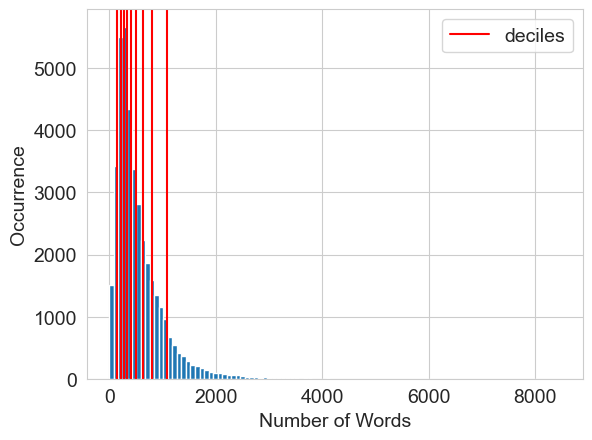

In [245]:
fig, ax = plt.subplots()
df['n_tokens_content'].hist(ax=ax, bins=100)
for pos in deciles:
    handle = plt.axvline(pos, color='r')
ax.legend([handle], ['deciles'], fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('Number of Words', fontsize=14)
ax.set_ylabel('Occurrence', fontsize=14)


In [246]:
# Visualize the deciles on the histogram


In [247]:
# Binning counts by quantiles
# Map the counts to quartiles
pd.qcut(large_counts, 4, labels=False)

array([1, 2, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 2, 1, 0, 3])

In [248]:
# Compute the quantiles themselves
large_counts_series = pd.Series(large_counts)
large_counts_series.quantile([0.25, 0.5, 0.75])

0.25     122.0
0.50     926.0
0.75    8286.0
dtype: float64

<b><h3>Log Transformation</h3></b>

The log function is the inverse of the exponential function. It is defined such that log<sub>a</sub>(a<sup>x</sup>)=x, where a is a positive constant, and x can be any positive number. Since a<sup>0</sup>=1, we have that log<sub>a</sub>(1)=0 and log<sub>a</sub>(0) = -∞. This means that the log function maps the small range of numbers between (0,1) to the entire range of negative numbers (-∞, 0). The function log<sub>10</sub>(x) maps the range of [1,10] to [0,1], [10, 100] to [1,2] and so on. In other words, the log function compresses the range of large numbers and expands the range of small numbers. The larger x is, the slower loge(x) increments. So for log<sub>10</sub>(x), the small range [0,100] is mapped to [0,2] and the large range of [100,1000] is mapped to [2,3]

The log transformation is a powerful tool for dealing with positive numbers with a heavy-tailed distribution. A heavy-tailed distribution places more probability mass in the tail range than a Gaussian distribution. It compresses the long tail in the high end of the distribution into a shorter tail, and expands the low end into a longer head.

<b><h5>Online News Popularity dataset</h5></b>

The dataset includes 60 features of a set of 39,797 news articles published by Mashable over a period of 2 years. Our goal is to use these features to predict the popularity of the articles in terms of the number of shares on social media. Here we'll focus on only one feature - the number of words in the article. Looking at the histograms of the feature before and after log transformation, we notice that the distribution looks much more Gaussian after log transformation, with the exception of the burst of number of articles of length zero (no content).

In [249]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

In [250]:
# +1 to have non-zero values
df['log_n_tokens_content'] = np.log10(df['n_tokens_content'] + 1) 

In [251]:
df

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,log_n_tokens_content
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,2.342423
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,2.408240
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,2.326336
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,2.725912
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,3.030600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,...,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800,2.540329
39640,http://mashable.com/2014/12/27/seth-rogen-jame...,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,...,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900,2.517196
39641,http://mashable.com/2014/12/27/son-pays-off-mo...,8.0,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,...,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900,2.646404
39642,http://mashable.com/2014/12/27/ukraine-blasts/,8.0,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,...,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100,2.834421


Text(0, 0.5, 'Occurrences')

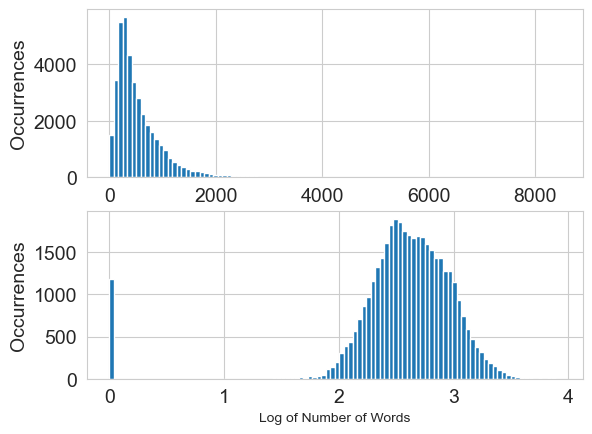

In [277]:
# Visualizing the distribution of news article popularity with and without log transformation
# log transformation converts a long-tailed distribution to a Gaussian
fig, (ax1, ax2) = plt.subplots(2,1)
df['n_tokens_content'].hist(ax=ax1, bins=100)
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Number of Words in Article', fontsize=14)
ax1.set_ylabel('Occurrences', fontsize=14)

df['log_n_tokens_content'].hist(ax=ax2, bins=100)
ax2.tick_params(labelsize=14)
ax2.set_xlabel('Log of Number of Words')
ax2.set_ylabel('Occurrences', fontsize=14)

<b><h4>Log Transform In Action</h4></b>

Let's see how the log transform performs for supervised learning. For the Mashable new articles, we'll use the number of words in an article to predict its popularity. Since the output is a continuous number, we'll use simple linear regression as the model. We use scikit-learn to perform 10-fold cross validation of linear regression on the feature with and without log transformation. The models are evaluated by the R-squared score, which measures how well a trained regression model predicts new data. Good models have high R-squared scores. A perfect model gets the maximum score of 1. The score can be negative, and a bad model can get an aribitrarily low negative score. Using cross validation, we obtain not only an estimate of the score but also a variance, which helps us guage whether the differences between the two models are meaningful. 

In [253]:
# Train two linear regression models to predict the number of shares of an article, one using the original feature
# and the other using the log transformed version.

m_orig = linear_model.LinearRegression()
scores_orig = cross_val_score(m_orig, df[['n_tokens_content']], df['shares'], cv=10)

m_log = linear_model.LinearRegression()
scores_log = cross_val_score(m_log, df[['log_n_tokens_content']], df['shares'], cv=10)

print(f"R-squared score with original feature: {scores_orig.mean():.5f}/(+/-{scores_orig.std()*2 :.5f})")
print(f"R-squared score with log transformed feature: {scores_log.mean():.5f}(+/-{scores_log.std()*2 :.5f})")

R-squared score with original feature: -0.00242/(+/-0.00509)
R-squared score with log transformed feature: -0.00114(+/-0.00418)


When computing the log transformed feature, we add 1 to the raw count to prevent the logarithm from exploding into negative infinity in case the count is zero. When we build the models and look at the R-squared values, the log transformed feature is doing better than the one without. Why is the log transfrom more successful on this dataset? We can get a clue by looking at the scatter plots of the input feature and target values.

The log transform reshaped the x-axis, pulling the articles with large outliers in the target value (>200,000) shares further out toward the righthand side of the axis. This gives the linear model more 'breathing room' on the low end of the input feature space. Without the log transform, the model is under more pressure to fit very different target values under very small changes in the input.

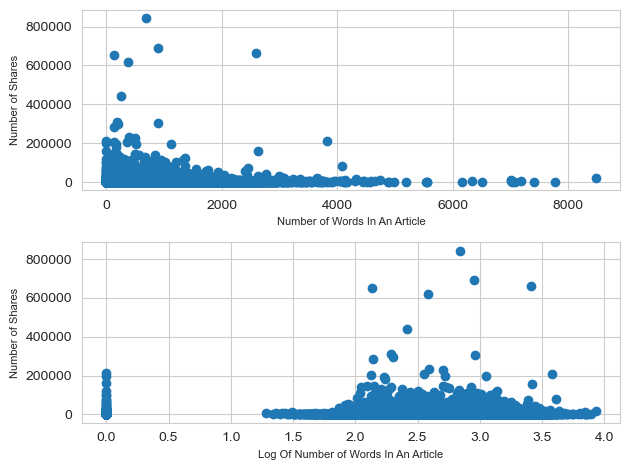

In [254]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
ax1.scatter(df[['n_tokens_content']], df['shares'])
ax1.tick_params(labelsize=10)
ax1.set_xlabel('Number of Words In An Article', fontsize=8)
ax1.set_ylabel('Number of Shares', fontsize=8)

ax2.scatter(df[['log_n_tokens_content']], df['shares'])
ax2.tick_params(labelsize=10)
ax2.set_xlabel('Log Of Number of Words In An Article', fontsize=8)
ax2.set_ylabel('Number of Shares', fontsize=8)
plt.tight_layout()

<b><h5>The Importance of Data Visualization</h5></b>

The comparison of the effect of the log transform on the dataset illustrates the importance of visualizing the data. Here, we intentionally kept the input and target variables simple so that we can easily visualize the relationship between them. Plots like the one above immediately reveal if the chosen model (linear) can or cannot represent the relationship between the chosen input and target. When building models, it is a good idea to visually inspect the relationship between input and output, and between different input features (scatter matrix).

<b><h4>Power Transforms: Generalization of the Log Transform</h4></b>

The log transform is a specific example of a family of transformations known as power transforms. In statistical terms, these are variance-stabilizing transformations. To understand why variance stabilization is good, consider the Poisson distribution. This is a heavy-tailed distribution with a variance that is equal to its mean: hence, the larger its center of mass, the larger the variance, and the heavier the tail. Power transforms change the distribution of the variable so that the variance is no longer dependent on the mean. For example, suppose a random variable X has the Poisson distribution. If we transform X by taking its square root, the variance of X' = X<sup>1/2</sup> is roughly constant, instead of being equal to the mean.

A simple generalization of both the square root transform and the log transform is known as the Box-Cox transform.
x~ = (x<sup>𝜆</sup>)/𝜆 if 𝜆 ≠ 0 else In(x) if 𝜆 = 0.

The Box-Cox formulation only works when the data is positive. For nonpositive data, one could shift the values by adding a fixed constant. When applying the Box-Cox transformation or a more general power transform, we have to determine a value for the parameter 𝜆. This may be done via maximum likelihood (finding the 𝜆 that maximizes the Gaussian likelihood of the resulting transformed signal) or Bayesian methods. SciPy's stats package contains an implementation of the Box-Cox transformation that includes finding the optimal transform parameter.

In [255]:
from scipy import stats

df.n_tokens_content.min()

0.0

In [256]:
rc_n_tokens_content = df.n_tokens_content + 1  # constant offset
rc_n_tokens_content.min()

1.0

In [257]:
# Setting input parameter lmbda to 0 gives us the log tranform (without constant offset)
rc_log = stats.boxcox(rc_n_tokens_content, lmbda=0)

In [258]:
# By default, the scipy implementation of Box-Cox transform finds the lambda parameter that will make the output 
# the closest to a normal distribution
rc_bc, bc_params = stats.boxcox(rc_n_tokens_content)

In [259]:
bc_params

0.38045297261832045

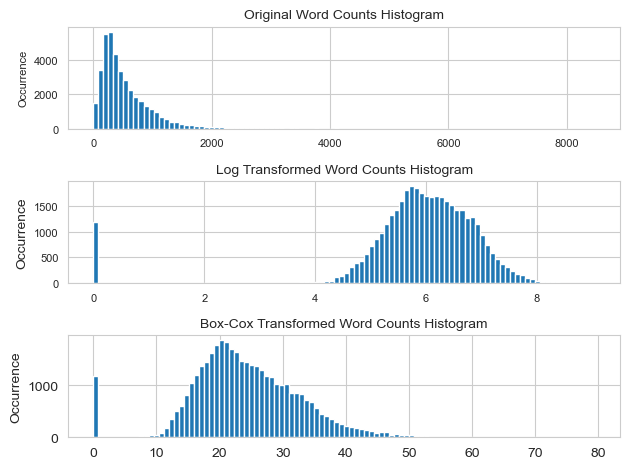

In [260]:
# Visualizing the histograms of original, log transformed, and Box-Cox transformed counts

fig, (ax1, ax2, ax3) = plt.subplots(3,1)

# original word count histogram
rc_n_tokens_content.hist(ax=ax1, bins=100)
ax1.tick_params(labelsize=8)
ax1.set_title('Original Word Counts Histogram', fontsize=10)
ax1.set_ylabel('Occurrence', fontsize=8)

# word count after log transform
pd.Series(rc_log).hist(ax=ax2, bins=100)
ax2.tick_params(labelsize=8)
ax2.set_title('Log Transformed Word Counts Histogram', fontsize=10)
ax2.set_ylabel('Occurrence', fontsize=10)
plt.tight_layout()

# word count after optimal Box-Cox transform
pd.Series(rc_bc).hist(ax=ax3, bins=100)
ax3.tick_params(labelsize=10)
ax3.set_title('Box-Cox Transformed Word Counts Histogram', fontsize=10)
ax3.set_ylabel('Occurrence', fontsize=10)

plt.tight_layout()

A probability plot, or probplot, is an easy way to visually compare an empirical distribution of data against a theoretical distribution. This is essentially a scatter plot of observed versus theoretical quantiles.

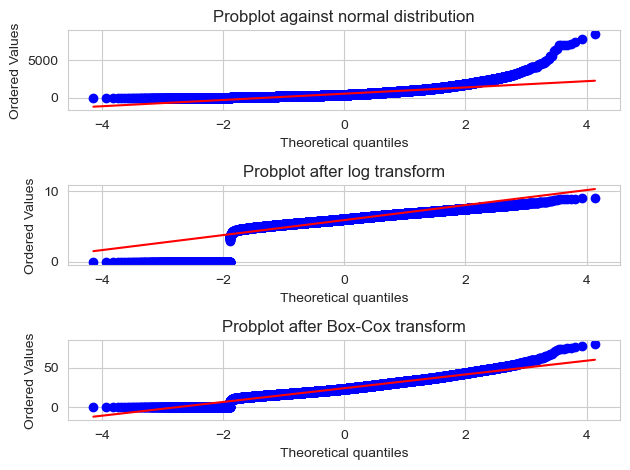

In [261]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
prob1 = stats.probplot(rc_n_tokens_content, dist=stats.norm, plot=ax1)
ax1.set_title('Probplot against normal distribution')

prob2 = stats.probplot(rc_log, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after log transform')

prob3 = stats.probplot(rc_bc, dist=stats.norm, plot=ax3)
ax3.set_title('Probplot after Box-Cox transform')

plt.tight_layout()

In [262]:
len(rc_bc) == len(df['shares'])



True

In [263]:
m_log = linear_model.LinearRegression()
scores_bc = cross_val_score(m_log, rc_bc.reshape(-1,1), df['shares'], cv=10)
print(f"R-squared score with original feature: {scores_bc.mean():.5f}/(+/-{scores_bc.std()*2 :.5f})")

R-squared score with original feature: -0.00177/(+/-0.00411)


<b><h3>Feature Scaling or Normalization</h3></b>

Some features, such as latitude or longitude, are bounded in value. Other numeric features, such as counts, may increase without bound. Models that are smooth functions of the input, such as linear regression, logistic regression, or anything that involves a matrix, are affected by the scale of the input. Tree-based models, on the other hand, couldn't care less. If your model is sensitive to the scale of input features, feature scaling could help. As the name suggests, feature scaling changes the scale of the feature. Sometimes people also call it feature normalization. Feature scaling is usually done individually to each feature.

<b><h4>Min-Max Scaling</h4></b>

Let x be an individual feature value (i.e., a value of the feature in some data point), min(x) and max(x) respectively be the minimum and maximum values of this feature over the entire dataset. Min-max scaling squeezes (or stretches) all feature values to be within the range of [0,1].

x~ = (x - min(x))/(max(x) - x)

<b><h4>Standardization (Variance Scaling)</h4></b>

Feature standardization is define as : 

x~ = (x - mean(x))/(sqrt(var(x)))

It subtracts off the mean of the feature (over all data points) and divides by the variance. Hence, it can also be called variance scaling. The resulting scaled feature has a mean of 0 and a variance of 1. If the original feature has a Gaussian distribution, then the scaled feature does too.

<b><h4>Don't 'Center' Sparse Data</h4></b>

Use caution when performing min-max scaling and standardization on sparse features. Both subtract a quantity from the original feature value. For min-max scaling, the shift is the minimum over all the values of the current feature; for standardization, it is the mean. If the shift is not zero, then these two transforms can turn a sparse feature vector whre most values are zero into a dense one (where the previously zero values contain negative values). This in turn could create a huge computational burden for the classifier, depending on how it is implemented (not to mention it would be horrendous if the representation now included every word that didint appear in a document!). Bag-of-words is a sparse representation, and most classification libraries for sparse inputs.

<b><h4>l<sup>2</sup> Normalization</h4></b>

This technique normalizes (divides) the original feature value by what's known as the l<sup>2</sup> norm, also known as the Euclidean norm. It's defined as follows:

x~ = x / || x||<sub>2</sub>

The l<sub>2</sub> norm measures the length of the vector in coordinate space. The definition can be derived from the well-known Pythagorean theorem that gives us the length of the hypotenuse of a right triangle given the lengths of the sides:

|| x||<sub>2</sub> = √(x<sub>1</sub><sup>2</sup> + x<sub>2</sub><sup>2</sup> + ... + x<sub>m</sub><sup>2</sup>)

The l<sub>2</sub> norm sums the squares of the values of the features across data points, then takes the square root. After l<sub>2</sub> normalizatioin, the feature column has norm 1. This is also called l<sup>2</sup> scaling. (Loosely speaking, scaling means multiplying by a constant where normalization could involve a number of operations). No matter the scaling method, feature scaling always the feature by a constant (known as normalization constant). Therefore it does not change the shape of the single-feature distribution.


Notice that this implementation of the l<sup>2</sup> norm is in data space, not feature space. One can also do l<sup>2</sup> normalization for the data point instead of the feature, which will result in data vectors with unit norm.

In [264]:
import sklearn.preprocessing as preproc

# Look at the original data - the number of words in an article
df['n_tokens_content'].values

array([219., 255., 211., ..., 442., 682., 157.])

In [265]:
# Min-max scaling
df['minmax'] = preproc.minmax_scale(df[['n_tokens_content']])

In [266]:
df['minmax'].values

array([0.02584376, 0.03009205, 0.02489969, ..., 0.05215955, 0.08048147,
       0.01852726])

In [267]:
# Standardization - note that by definition, some outputs will be negative
df['standardized'] = preproc.StandardScaler().fit_transform(df[['n_tokens_content']])
df['standardized'].values

array([-0.69521045, -0.61879381, -0.71219192, ..., -0.2218518 ,
        0.28759248, -0.82681689])

In [268]:
# L2 normalization
df['l2_normalized'] = preproc.normalize(df[['n_tokens_content']], axis=0) #axis=0 to normalize features not datapoint

In [269]:
df['l2_normalized'].values

array([0.00152439, 0.00177498, 0.00146871, ..., 0.00307663, 0.0047472 ,
       0.00109283])

Text(45.347222222222214, 0.5, 'Number of articles')

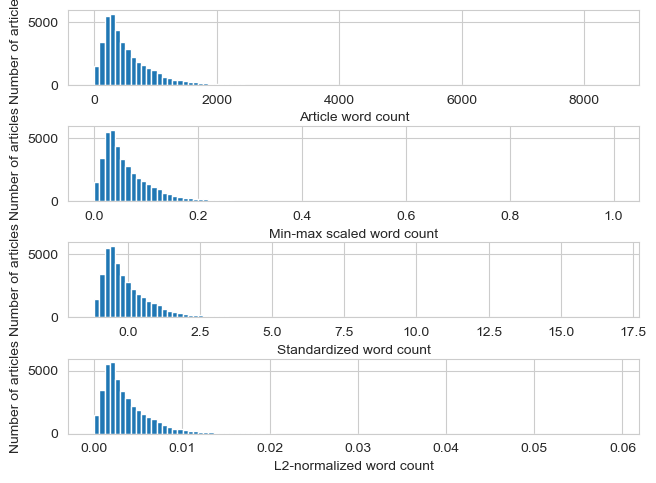

In [275]:
# Visualization of the distibution of data with different feature scaling methods
# Feature scaling doesnt change the shape of the distribuitio because of the dividend aka normalization constant
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.tight_layout()
df['n_tokens_content'].hist(ax=ax1, bins=100)
ax1.tick_params(labelsize=10)
ax1.set_xlabel('Article word count', fontsize=10)
ax1.set_ylabel('Number of articles', fontsize=10)

df['minmax'].hist(ax=ax2, bins=100)
ax2.tick_params(labelsize=10)
ax2.set_xlabel('Min-max scaled word count', fontsize=10)
ax2.set_ylabel('Number of articles', fontsize=10)

df['standardized'].hist(ax=ax3, bins=100)
ax3.tick_params(labelsize=10)
ax3.set_xlabel('Standardized word count', fontsize=10)
ax3.set_ylabel('Number of articles', fontsize=10)

df['l2_normalized'].hist(ax=ax4, bins=100)
ax4.tick_params(labelsize=10)
ax4.set_xlabel('L2-normalized word count', fontsize=10)
ax4.set_ylabel('Number of articles', fontsize=10)

Feature scaling is useful in situations where a set of input features differ wildly in scale. For instance, the number of daily visitors to a popular ecommerce site might be a hundred thousand, while the actual number of sales might be in the thousands. If both of those features are thrown into a model, then the model will need to balance its scale while figuring out what to do. Drastically varying scale in input features can lead to numeric stability issues for the model training algorithm. In those situations, its a good idea to standardize the features.

<b><h4>Interaction Features</h4></b>

A simple pairwise interaction feature is the product of two features. The analogy is the logical AND. It expresses the outcome in terms of pairs of conditions: "the purchase is coming from zip code 98121" AND "the user's age is between 18 and 35". Decision tree-based models get this for free, but generalized linear models often find interaction features very helpful.

A simple linear model uses a linear combination of the individual input features x<sub>1</sub>, x<sub>2</sub>,..., x<sub>n</sub> to predict the outcome y.

y = w<sub>1</sub>x<sub>1</sub> + w<sub>2</sub>x<sub>2</sub> + ... + w<sub>n</sub>x<sub>n</sub>

An easy way to extend the linear model is to include combinations of pairs of input features:

y = w<sub>1</sub>x<sub>1</sub> + w<sub>2</sub>x<sub>2</sub> + ... + w<sub>n</sub>x<sub>n</sub> + w<sub>1,1</sub>x<sub>1</sub></sub>x<sub>1</sub> + w<sub>1,2</sub>x<sub>1</sub></sub>x<sub>2</sub> + w<sub>1,3</sub>x<sub>1</sub></sub>x<sub>3</sub>

This allows us to capture interactions between features, and hence these pairs are called interaction features. If x<sub>1</sub> and x<sub>2</sub> are binary, then their product x<sub>1</sub>x<sub>2</sub> is the logical function x<sub>1</sub> AND x<sub>2</sub>. Suppose the problem is to predict a customer's preference based on their profile information. In our example, instead of making predictions based solely on the age or location of the user, interaction features allow the model to make predictions based on the user being of a certain age AND at a particular location.

In [278]:
from sklearn.model_selection import train_test_split

In [280]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

In [285]:
# Select the content-based features as singleton features in the model, skipping over derived features

features = ['n_tokens_title', 'n_tokens_content',
 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
 'data_channel_is_entertainment', 'data_channel_is_bus',
 'data_channel_is_socmed', 'data_channel_is_tech',
 'data_channel_is_world']

X = df[features]
y = df[['shares']]  # putting the singular target in square brackets before slicing yields a DataFrame
X.shape

(39644, 17)

In [286]:
# Create pairwise interaction features, skipping the constant bias term
X2 = preproc.PolynomialFeatures(include_bias=False).fit_transform(X)
X2.shape

(39644, 170)

In [287]:
# Create train/test sets for both feature sets
# Turns out you can provide two X's and a common y for splitting *arrays same shape[0]
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X,X2, y, test_size=0.3, random_state=123)

In [297]:
def evaluate_feature(X_train, X_test, y_train, y_test):
    """ Fit a linear regression model on the training set and score on the test set
    """
    model = linear_model.LinearRegression().fit(X_train, y_train)
    r_score = model.score(X_test, y_test)
    return (model, r_score)

In [298]:
(m1,r1) = evaluate_feature(X1_train, X1_test, y_train, y_test)
(m2,r2) = evaluate_feature(X2_train, X2_test, y_train, y_test)
print(f"R-squared score with singleton features: {r1:.5f}")
print(f"R-squared score with pairwise features: {r2:.5f}")

R-squared score with singleton features: 0.00924
R-squared score with pairwise features: 0.01133


Interaction features are very simple to formulate, but they are expensive to use. The training and scoring time of a linear model with pairwise interaction features would go from O(n) to O(n<sup>2</sup>) where n is the number of singleton features.

There are a few ways around the computational expense of higher-order interaction features. One could perform feature selection on top of all of the interaction features. Alternatively, one could more carefully craft a smaller number of complex features.

Both strategies have their advantages and disadvantages. Feature selection employs computational means to select the best featues for a problem. (This technique is not limited to interaction features.) However, some feature selection techniques still require training multiple models with a large number of features.

Handcrafted complex features can be expressive enough that only a small number of them are needed, which reduces the training time of the model - but the features themselves may be expensive to compute which increases the computational cost of the model scoring stage.

<b><h4>Feature Selection</h4></b>

Feature selection techniques prune away nonuseful features in order to reduce the complexity of the resulting model. The end goal is a parsimonious model that is quicker to compute, with little or no degradation in predictive accuracy. In order to arrive at such a model, some feature selection techniques require training more than one candidate model. In other words, feature selection is not about reducing training time - in fact, some techniques increase overall training time - but about reducing model scoring time.

Roughly speaking, feature selection techniques fall into three classes:

- Filtering : Filtering techniques preprocess features to remove ones that are unlikely to be useful for the model. For example, one could compute the correlation or mutual information between each feature and the response variable and filter out the feature that fall below a threshold. Filtering techniques are much cheaper than the wrapper techniques , but they do not take into account the model being employed. Hence, they may not be able to select the right features for the model. It is best to do prefiltering consevatively, so as not to inadvertently eliminate useful features before they make it to the model training step.

- Wrapper methods: These techniques are expensive, but they allow you to try out subsets of features, which means you won't accidentally prune away features that are uninformative by themselves but useful when taken in combination (the failing of filtering). The wrapper method treats the model as a black box that provides a quality score of a proposed subset for features. 

- Embedded methods : These methods perform feature selection as part of the model training process. For example, a decision tree inherently performs feature selection because it selects one feature on which to split the tree at each training step. Another example is the l<sup>1</sup> regularizer, which can be added to the training objective of any linear model. The l<sup>1</sup> regularizer encourages models that use a few features as opposed to a lot of features, so its also known as sparsity constraint on the model. Embedded methods incorporate feature selection as part of the model training process. They are not as powerful as wrapper methods, but they are nowhere near as expensive. Compared to filtering, embedded methods select features that are specific to the model. In this sense, embedded methods strike a balance between computational expense and quality of results.